# Cox & Munk
## Statistical distribution of the random sea surface slopes

Statistical distribution of the random sea surface slopes (a bivariate Gaussian). Cox-Munk statistics include capillary waves and gravity waves.

$$ p(\eta_a,\eta_c) = \frac{1}{2\pi \sigma_a \sigma_c}\exp[-\frac{1}{2}(\frac{\eta_a^2}{\sigma^2_a} + \frac{\eta^2_c}{\sigma^2_c})]$$

$p(\eta_a,\eta_c)$ is normalised such that the area under it is 1

where $\eta$ is the wave elevation, distributed normally with zero mean and variance, $\eta_a$ and $\eta_c$ are the along-wind (upwind) and crosswind slopes of the water surface respectively. 
$\eta_a = \frac{\delta \eta}{\delta x_a}, \eta_c = \frac{\delta \eta}{\delta x_c}$. 
It is known from experiment that the capillary wave slopes $\eta_a$ and $\eta_c$ vary in a random manner, being independently and normally distributed with zero mean and variances.

## Wave-slope wind-speed law

### Cox-Munk Capillary wave slope equations

- It should be emphasized that they also represent the *slopes* of a gravity-capillary wave surface. Most of the variance in the slope of the sea surface is due to the shortest wavelength of capillary waves. 
- Most of the variance in the *amplitude* of the surface waves id due to the longest gravity waves.
- For optics, it is the *slope* of the surface that is the most important because the slope determines the angles entering the Fresnel reflectance equations for an incident ray.
- The amplitude of the waves determines the amount of wave "shadowing" at low solar elevations and influences multiple scattering between gravity waves, but the effects are insignificant unless viewing from near-horizon sun positions

$\sigma^2_a = a_a U,$ where $a_u = 3.16\times 10^{-3} s/m$

$\sigma^2_c = a_c U$, where $a_c = 1.92\times 10^{-3} s/m$



These slope variances were found to be related to the wind speed $U$ which is the wind speed (in m/s) measured at an anemometer height of 12.5 m above mean sea level

$$\sigma^2_a = 0.000 + 3.16 \cdot 10^{-3}U \pm 0.004$$

$$\sigma^2_c = 0.003 + 1.92 \cdot 10^{-3}U \pm 0.002$$

$$\sigma^2 = \sigma^2_a + \sigma^2_c = 0.003 + 5.12 \cdot 10^{-3}U \pm 0.004$$

# Modelling capillary waves

We need to construct a large number of random capillary-wave surfaces

1. Partition a horizontal plane into a hexagonal grid of congruent isosceles triangle (aka triads), where $\delta$ and $\in$ are the base and same-length sides of an isosceles triangle
2. $\delta$-dimension is aligned along the wind direction
3. Vertices of the triad are labelled $v_1, v_2, v_3$
4. Randomly draw 3 values ($\eta_1, \eta_2, \eta_3$) from $~N(0,\sigma^2)$ (Note that $\eta$ can be < 0, positive $\eta$ corresponds to points below mean sea level since depth is defined as positive)
5. Draw 3 vertical lines (parallel to $\hat{i_3}$) through the respective vertices with the heights $\eta_1, \eta_2, \eta_3$
6. The 3 points connect to form a facet of the surface, and repeat for all surfaces (Note that only the first facet requires us to draw 3 values, since 2 other values are always defined already, only value needs to be drawn for other facets.). The facets represent individual capillary wave facets

The upwind and crosswind slopes of a facet is defined as:

$\eta_a = \frac{\eta_1 - \eta_2}{\delta}$ and $\eta_c = \frac{\eta_3 - 0.5(\eta_1 + \eta_2)}{\in}$

$\eta_a$ and $\eta_c$ are independent of each other, and thus uncorrelated

Elevation of a wave facet is defined as $\eta = \frac{\eta_1 + \eta_2 + \eta_3}{3}$, average height of the facet's centroid above or below the plane of the hexagonal grid

## Defining scales

- Fix the horizontal sizes $\delta$ and $\in$ and the vertical scale $\sigma$ of the random wave facets as a function of the wind speed $U$
$$\sigma^2_a = \frac{2\sigma^2}{\delta^2} = a_a U$$

$$\sigma^2_c = \frac{3\sigma^2}{2\in^2} = a_c U$$

Since $U$ is the same,

$$ \frac{\in^2}{\delta^2} = \frac{3 a_a}{4 a_c}$$

- The *shape* of the triad is thus independent of the wind speed and of the physical units of $\delta$ and $\in$, as proven mathematically. Thus, only the vertical scale of the capillary surface changes with the wind speed. 
- Since only the slope and orientation of the facet matters for ray-tracing, $\delta$ can be defined as 1. We can then fix $\in$ and $\sigma$


In [81]:
%matplotlib widget

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


### Generate triangular mesh

In [9]:
a_u = 3.16e-3
a_c = 1.92e-3
n = 30 #cell size of grid
delta = 1 #along wind
eps = np.sqrt((3*a_u)/(4*a_c)) #cross wind
X = np.linspace(0,n,num=n,endpoint=False)
Y = np.arange(0,n*eps,step=eps) #np.linspace(0,n,num=n,endpoint=False)

Text(0.5, 1.0, 'triplot of Delaunay triangulation')

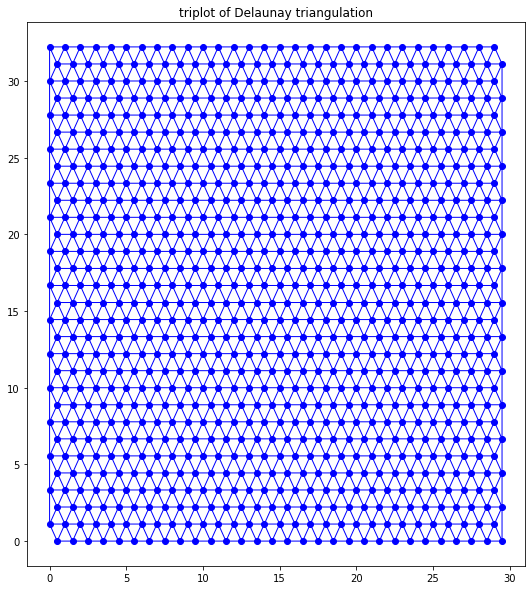

In [10]:
x , y = np.meshgrid(X,Y)
x[::2,:] += 0.5 #half the width of delta
x = x.flatten()
y = y.flatten()
triang = mpl.tri.Triangulation(x, y) ## Triangulate parameter space to determine the triangles using a Delaunay triangulation

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.set_aspect('equal')
ax1.triplot(triang, 'bo-', lw=1)
ax1.set_title('triplot of Delaunay triangulation')

In [11]:
U = 10 # wind speed: 10 m/s
sigma_a = a_u*U
sigma_c = 0.003 + a_c*U
sigma = sigma_a + sigma_c
print(sigma)
sigma = 0.003 + 5.12e-3*U
print(sigma)
np.random.seed(seed=4)
n_dist = np.random.normal(loc=0,scale = np.sqrt(sigma),size = x.shape[0])
print(np.mean(n_dist))

0.0538
0.054200000000000005
0.015064843116805093


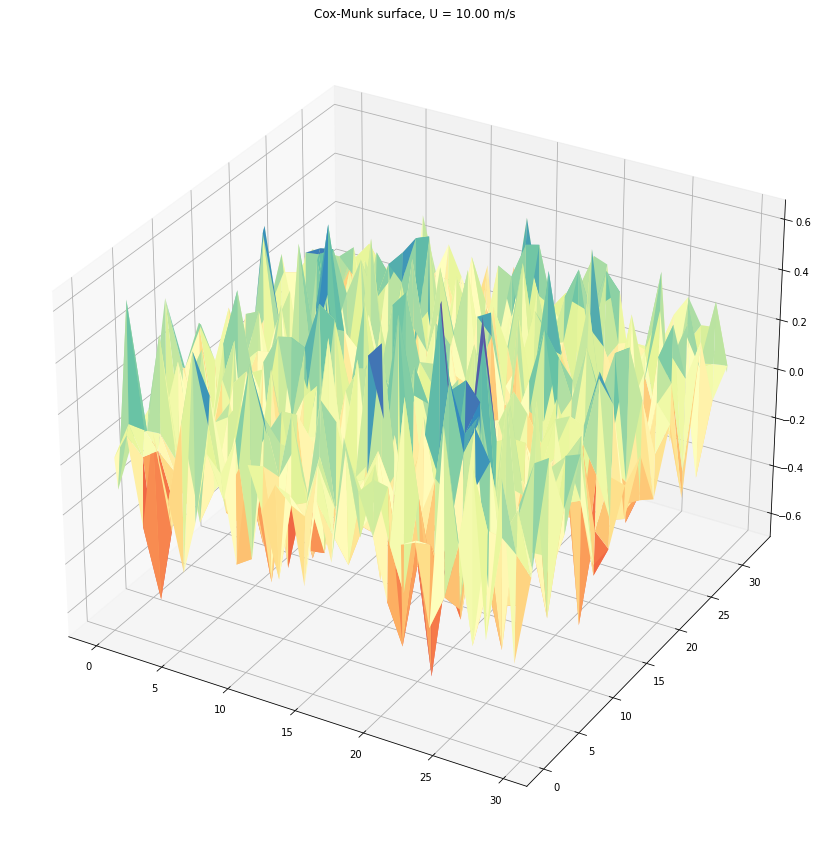

In [13]:
# Plot the surface.  The triangles in parameter space determine which x, y, z points are connected by an edge.
ax = plt.figure(figsize=(15,15)).add_subplot(projection='3d')
# ax = Axes3D(ax)
ax.plot_trisurf(triang,n_dist, linewidth=0.2, antialiased=True,cmap=plt.cm.Spectral) #3d surface
ax.set_title("Cox-Munk surface, U = {:.2f} m/s".format(U))
plt.show()

# Ray Tracing

- In general, each encounter of a ray with a wave facet generates both reflected and a refracted daughter ray
- The directions and radiant powers of these daughter rays are determined by Snell's law and Fresnel's formula (the daughter rays may undergo further encounters with other wave facets)
- In essence, the ray-tracing procedure devolves on repeatedly finding the intersection of a straight line and a triangular plane facet in space

1. intialise wind speed and direction
2. construct a random surface over the hexagonal grid
3. an initial ray incident along the desired direction. The parent ray may approach the surface from the air/water side. The parent ray $\hat{\xi}$ is assigned a radiant power $\Phi ' = 1$, and the point $\overrightarrow{p}'$ where the ray enters the hexagonal domain (e.g. point A). The information ($\hat{\xi}, \Phi ',\overrightarrow{p}'$) is then stored in an array, called the *stack*
4. pull the next triple array $\hat{\xi}, \Phi ',\overrightarrow{p}'$ from the stack then trace the ray to completion
5. Extend the ray from point $\overrightarrow{p}'$ along direction $\hat{\xi}$ until either the ray encounters a surface or leaves the hexagonal grid. The point $\overrightarrow{p}_i$ of interception of the ray and the surface is determined, and daughter rays are produced
6. one daughter ray will be generated at $\overrightarrow{p}_i$ along the reflected direction $\hat{\xi}_r$.
7. One daughter ray will be generated along $\hat{\xi}_t$ iff the ray is not totally internally reflected at $\overrightarrow{p}_i$.
8. the direction of the parent ray $\hat{\xi}$, the normal $\hat{n}$ to the intercepted wave facet, and the daughter ray direction $\hat{\xi}_r$ determine an associated Fresnel factor for reflectance. The Frenel factor is multiplied into the current radiant power $\Phi$ of the parent ray to obtain the power $\Phi_r$ of the reflected daughter ray. The power of the transmitted ray is thus $\Phi_t = \Phi - \Phi_r$. The daughter ray triples are pushed into the stack for further processing.

See Chapter 4 (Light & Water), page 178

It is easier to write down a recursive formula for the radiant power of a newly born daughter ray at each step between the beginning and end of the parent ray's travels.
we know the values ($\hat{\xi}, \Phi ',\overrightarrow{p}'$) of a parent ray. Tracing the ray from $\overrightarrow{p}$ to an interception point $\overrightarrow{p}_i$ along $\hat{\xi}$ yields a calculable distance $d = |\overrightarrow{p} - \overrightarrow{p}_i|$. The outward normal $\hat{n}_i$ we can decide whether the path of the ray was in air or in water by finding whether $\hat{\xi} \cdot \hat{n}_i < 0$ (air-incident case) or $\hat{\xi} \cdot \hat{n}_i > 0$ (water-incident case)
In the case of total internal reflection, $r(\hat{\xi} \cdot \hat{n}_i) = 1$, and there is no refracted ray

Let $\Phi(I)$ be the downward incident radiant power over patch I of the upper h.m.s of a realisation $S(\omega)$ of the random water surface. This $\Phi(I)$ is produced by the ray of radiance ($L(\hat{\xi '})$) about direction $\hat{\xi '}$

$\Delta \Omega = $ solid angle

$\Delta A$ = area of the ray normal to $\hat{\xi '}$ (area where the incident ray hits)

$\Phi(I) = L(\hat{\xi '}) \Delta \Omega \Delta A$

The upward emergent power $\Phi (R;\omega) = \Phi(I) r_+(\hat{\xi '};\omega) = L(\hat{\xi '}) \Delta \Omega \Delta A  r_+(\hat{\xi '};\omega)$

Most simulations were performed for collimated incident radiance distributions ($L(\hat{\xi '})$) i.e. for all $\hat{\xi '}$ exactly the same, which corresponds to an infinitely distant, point sun in a black sky

The incident ray direction $\hat{\xi '}$ is specified by ($\theta_s ', \phi_s '$), where $\theta_s '$ is the polar angle of the light *source* measured from either the zenith or the nadir direction.

A source located in the downwind direction has $\phi_s ' = 0$

Section 7 of Preisendorfer & Mobley (1985) presents a model-generated glitter pattern for both reflected and transmitted rays starting from both above and below the water surface

### Observations

- incident rays from the zenith (nadir) on a flat air-water surface, 98% of the beam's radiant flux penetrates into the sea below
- Beam incident at 80 degrees from the zenith has only 65% penetration
A wind-ruffled surface allows more transmission of light into sea, compared to a flat calm surface
- First-order-ray-tracing theory is no longer statistically acceptable because the rays are likely to undergo multiple scatering among the wave facets. It also doesnt take into account of the shielding effect of one wave facet blocking rays from another.
- Due to the effect of multiple scattering of light rays, the net penetration of light into the sea decreases, since there are more opportunities for the sea surface to reflect the light back into the sky. However, the shielding of a wave facet increases the light penetration because of increased interception. The net effect of multiple scattering and shielding increases sea surface radiance reflectance for wind speeds
- Normals to the capillary wave facets in the alongwind vertical plane tend on average to be tipped away from the vertical at greater angles than those in the crowsswind vertical plane
- Hence light rays incident, at a fixed zenith angle, on the rippled sea surface in the alongwind plane on average undergo a greater transmission in the sea compared to those incident in the crosswind plane
- Ergodic equivalence of time-averaged wave slop statistics and space-averaged wave slope statistics

# Coordinate system notations

- $\overrightarrow{i}$ downwind
- $\overrightarrow{k}$ perpendicular to mean sea level, and positive upward
- and $\overrightarrow{j} = k \times i$ in the crosswind direction
 
## Ray-tracing in the wind-based system

- An arbitrary vector $u$ in space within the hexagonal domain is:
$$\overrightarrow{u} = u_1\overrightarrow{i} +  u_2\overrightarrow{j} + u_3\overrightarrow{k} = (u_1,u_2,u_3)$$

- Specifying directions of rays, surface normals, we will use unit vectors ($\hat{u}$)
- $\hat{u}$, are also defined in terms of zenith angle ($\theta = \arctan(\hat{u} \cdot k) = \arctan(u_3)$), 
- and an azimuth angle $\phi = \arctan (u_2/u_1)$
$$ \hat{u} = (\sin \theta \cos \phi, \sin \theta \sin \phi, \cos \theta) , 0^o \leq \theta \leq 180^o , 0^o \leq \phi \leq 360^o$$